# Giải thích notebook: Copula Portfolio Risk Simulation

Notebook này trình bày quy trình mô phỏng rủi ro danh mục đầu tư dựa trên mô hình copula, kết hợp với các phân phối biên được ước lượng từ mô hình GARCH và EVT. Các bước chính bao gồm:

1. **Tính toán PIT (Probability Integral Transform)**: Chuyển đổi các phần dư chuẩn hóa sang phân phối đều bằng các phân phối biên EVT.
2. **Kiểm định và trực quan hóa PIT**: Kiểm tra tính phân phối đều của PIT bằng các biểu đồ ECDF, histogram, ACF và scatter plot với Kendall's tau.
3. **Ước lượng và mô phỏng copula**: Fit mô hình copula cho dữ liệu PIT, sau đó mô phỏng các mẫu mới cho danh mục đầu tư.
4. **Phân tích kết quả mô phỏng**: Tính toán các chỉ số rủi ro như VaR, ES cho từng tài sản và toàn bộ danh mục, so sánh với dữ liệu thực tế.

Các cell trong notebook thực hiện tuần tự các bước trên, sử dụng các hàm đã xây dựng trong module `copula_simulation.py`. Kết quả trực quan hóa giúp đánh giá chất lượng mô hình copula và khả năng mô phỏng rủi ro danh mục đầu tư.

## 1. Import thư viện và chuẩn bị dữ liệu

Import các thư viện cần thiết và các hàm đã xây dựng trong module `copula_simulation.py`.

In [41]:
import numpy as np
import pandas as pd
import pickle
from typing import Tuple, Dict
import importlib
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

import copula_simulation
importlib.reload(copula_simulation)
from copula_simulation import (
    compute_pit, validate_pit, fit_copula, load_copula_and_marginals, 
    simulate_copula_portfolio, comprehensive_analysis,
    plot_histogram_comparison, plot_pairplot_comparison
)

import os
os.makedirs('../models/copula', exist_ok=True)

## 2. Tính toán Probability Integral Transform (PIT)

PIT là bước chuyển đổi các phần dư chuẩn hóa từ mô hình GARCH sang phân phối đều trên [0, 1] bằng cách sử dụng các phân phối biên EVT đã ước lượng. Việc này giúp chuẩn hóa dữ liệu đầu vào cho mô hình copula, đảm bảo các biến đầu vào có cùng phân phối đều. 

### Tính toán PIT

Đoạn code dưới đây thực hiện việc tính toán PIT bằng hàm có sẵn `compute_pit`, lưu kết quả ra file và kiểm định tính phân phối đều của các giá trị PIT.

In [42]:
pit_df, evt_marginals = compute_pit(
    std_resids_path      ='../models/garch/standardized_residuals.csv',
    evt_marginals_path   ='../models/evt/marginal_distributions.pkl',
    clip_eps             =1e-12
)

pit_df.to_csv('../models/copula/pit_data.csv')
print(f"Saved PIT data: {pit_df.shape}")

Standardized residuals shape: (2611, 5)
Loaded EVT marginals: 5 keys
PIT shape: (2611, 5) | range after clip: [0.000138, 1]
Saved PIT data: (2611, 5)


- Residuals chuẩn hóa: Dữ liệu đã được chuẩn bị, sẵn sàng cho việc phân tích.
- Marginals được nạp: Mô hình đã tìm ra cách mô tả các giá trị cực trị của từng biến một cách độc lập.
- Biến đổi PIT: Dữ liệu được chuyển đổi để dễ dàng kiểm tra mối quan hệ phụ thuộc giữa các biến, bất kể chúng có phân phối gốc như thế nào.
- Lưu dữ liệu PIT: Kết quả chuyển đổi đã được lưu lại để xây dựng mô hình copula ở bước tiếp theo.

### Kiểm tra kết quả PIT

In [43]:
report = validate_pit(pit_df)

PIT shape: 2611 x 5
Range: [0.000138, 0.999859]
Edge rate: 0.000%
KS test: 5/5 passed (p≥0.01)


- PIT shape: Dữ liệu sau chuyển đổi vẫn giữ nguyên kích thước ban đầu.
- Range: Cho thấy các giá trị sau chuyển đổi nằm trong khoảng từ 0.000138 đến 0.999859.
- Edge rate: Tỉ lệ các giá trị nằm sát biên (rất gần 0 hoặc 1) là 0%, cho thấy quá trình chuyển đổi không tạo ra các giá trị ngoại lệ, đảm bảo chất lượng dữ liệu.
- KS test: Kiểm tra Kolmogorov-Smirnov. 5/5 biến đã vượt qua bài kiểm tra, chứng tỏ quá trình chuyển đổi sang phân phối đồng nhất là thành công và chính xác. (Với mức ý nghĩa p ≥ 0.01)

### Biểu đồ ECDF PIT với KS bands

Biểu đồ ECDF PIT với KS bands cho từng mã cổ phiếu (FPT, HPG, MBB, MWG, VIC) giúp kiểm tra trực quan chất lượng chuyển đổi dữ liệu sang phân phối đều.

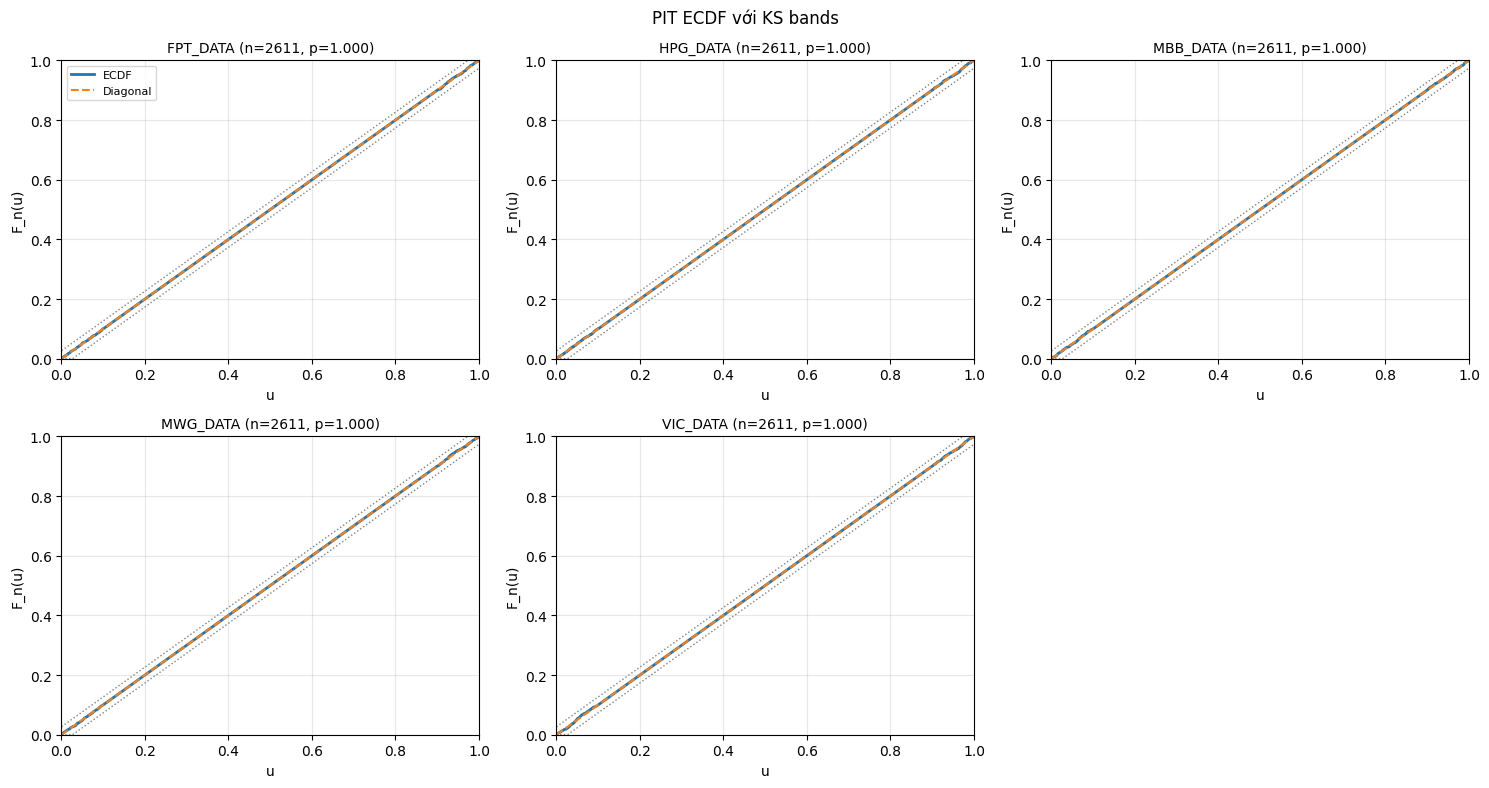

In [38]:
# ECDF plots với KS bands
import math
from scipy.stats import kstest


alpha, eps, max_cols = 0.05, 1e-6, 3
c_alpha = 1.36 if alpha == 0.05 else 1.22
cols = list(pit_df.columns)
nrows, ncols = math.ceil(len(cols)/max_cols), min(max_cols, len(cols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)
axes = axes.ravel()

for i, name in enumerate(cols):
    ax = axes[i]
    u = np.clip(pit_df[name].dropna().values, eps, 1-eps)
    n = u.size
    u_s = np.sort(u)
    Fn = np.arange(1, n+1) / n
    band = c_alpha / np.sqrt(n)
    
    # Plot ECDF + bands
    ax.plot(u_s, Fn, lw=2, label="ECDF")
    ax.plot([0, 1], [0, 1], lw=1.5, ls="--", label="Diagonal")
    ax.plot(u_s, np.minimum(u_s + band, 1.0), lw=1, ls=":", color='gray')
    ax.plot(u_s, np.maximum(u_s - band, 0.0), lw=1, ls=":", color='gray')
    
    # KS test p-value
    _, pval = kstest(u, 'uniform')
    ax.set_title(f"{name} (n={n}, p={pval:.3f})", fontsize=10)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.grid(alpha=0.3)
    ax.set_xlabel("u"); ax.set_ylabel("F_n(u)")
    if i == 0: ax.legend(fontsize=8)

# Ẩn subplot thừa
for j in range(len(cols), len(axes)): axes[j].axis('off')
plt.suptitle("PIT ECDF với KS bands", fontsize=12); plt.tight_layout(); plt.show()

- Đường ECDF thực nghiệm (màu xanh) gần như trùng khớp với đường chéo lý thuyết (màu cam), cho thấy dữ liệu PIT đã đạt được phân phối đều như mong muốn.
- Dải KS bands thể hiện ngưỡng kiểm định thống kê Kolmogorov-Smirnov. Khi ECDF nằm trong dải này và p-value kiểm định rất cao (p = 1.000), ta có thể kết luận quá trình chuyển đổi và mô hình biên đã phù hợp rất tốt với dữ liệu gốc.
- Kết quả này xác nhận đầu vào cho mô hình copula là hợp lệ, tạo nền tảng vững chắc cho các bước mô phỏng rủi ro tiếp theo.

Tóm lại, biểu đồ này là bằng chứng trực quan và thống kê cho thấy mô hình biên đã nắm bắt rất tốt đặc điểm của dữ liệu thực tế.

### Ý nghĩa biểu đồ histogram PIT

Biểu đồ histogram PIT cho từng mã cổ phiếu (FPT, HPG, MBB, MWG, VIC) trực quan hóa sự phân phối của các giá trị PIT sau khi chuyển đổi.

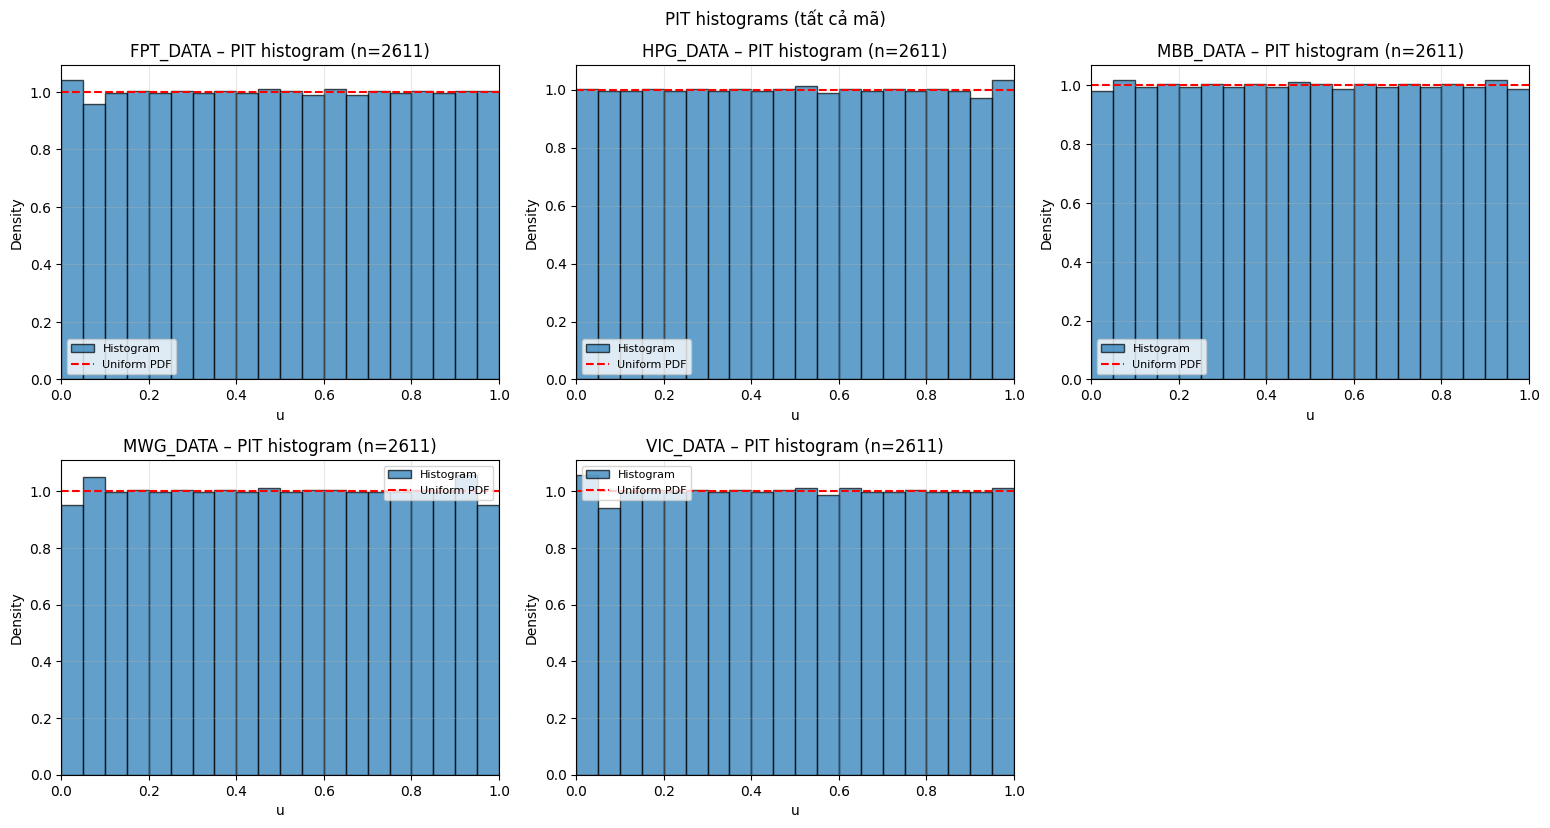

In [27]:
# PIT histograms cho tất cả tickers

bins, eps, max_cols = 20, 1e-6, 3
cols = list(pit_df.columns)
nrows, ncols = math.ceil(len(cols)/max_cols), min(max_cols, len(cols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.2, nrows*4.2), squeeze=False)
axes = axes.ravel()

for i, name in enumerate(cols):
    ax = axes[i]
    u = np.clip(pit_df[name].dropna().values, eps, 1-eps)
    
    # Plot histogram + uniform reference
    ax.hist(u, bins=bins, range=(0,1), density=True, edgecolor="black", alpha=0.7, label="Histogram")
    ax.axhline(1.0, color='red', ls="--", lw=1.5, label="Uniform PDF")
    
    ax.set(xlim=(0,1), xlabel="u", ylabel="Density", title=f"{name} – PIT histogram (n={u.size})")
    ax.grid(alpha=0.3); ax.legend(fontsize=8)

# Ẩn subplot thừa
for j in range(len(cols), len(axes)): axes[j].axis('off')
plt.suptitle("PIT histograms (tất cả mã)", fontsize=12); plt.tight_layout(); plt.show()

- Nếu histogram của các giá trị PIT nằm gần sát với đường phân phối đều lý thuyết (đường đỏ), điều này xác nhận dữ liệu đã được chuẩn hóa thành công.
- Sự đồng đều của các cột histogram cho thấy không có hiện tượng tập trung giá trị ở biên hoặc ở giữa, đảm bảo tính ngẫu nhiên và đồng nhất của dữ liệu PIT.
- Kết quả này là một kiểm tra bổ sung cho bước chuyển đổi PIT, giúp xác nhận lại chất lượng dữ liệu đầu vào cho mô hình copula.

### Biểu đồ ACF của Z = Φ⁻¹(U)

Biểu đồ ACF (Autocorrelation Function) của Z = Φ⁻¹(U) cho từng mã cổ phiếu giúp kiểm tra tính độc lập chuỗi thời gian sau khi chuẩn hóa PIT.

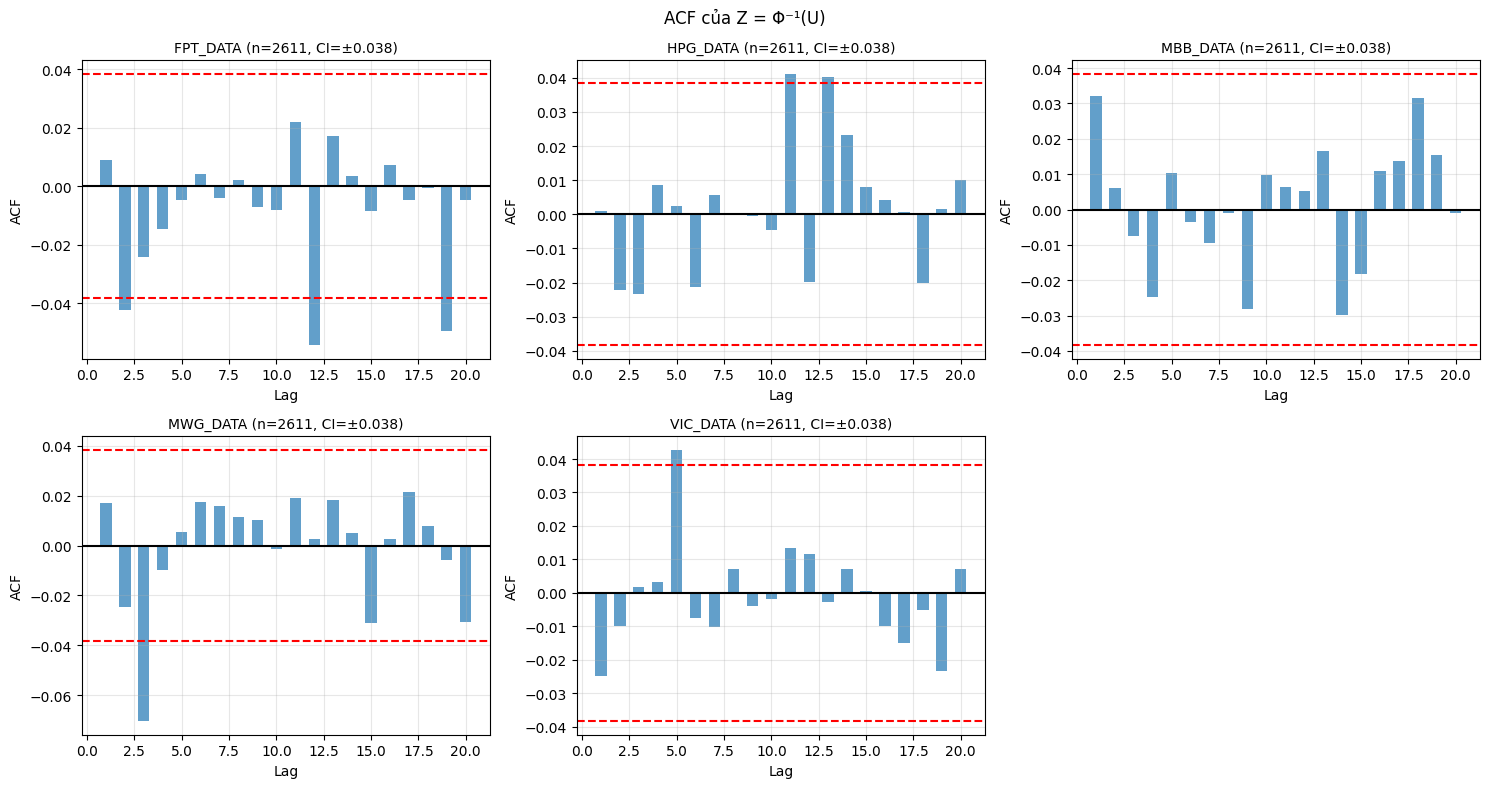

In [28]:
from scipy.stats import norm

# ACF plots cho tất cả tickers
eps, max_lag, max_cols = 1e-6, 20, 3
cols = list(pit_df.columns)
nrows, ncols = math.ceil(len(cols)/max_cols), min(max_cols, len(cols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)
axes = axes.ravel()

for i, name in enumerate(cols):
    ax = axes[i]
    u = np.clip(pit_df[name].dropna().values, eps, 1-eps)
    z = norm.ppf(u) - np.mean(norm.ppf(u))  # standardize
    n, conf = z.size, 1.96/np.sqrt(z.size)
    
    # Tính ACF
    acf = [np.corrcoef(z[:-k], z[k:])[0,1] if len(z) > k else 0 for k in range(1, max_lag+1)]
    
    # Plot
    ax.bar(range(1, max_lag+1), acf, width=0.6, alpha=0.7)
    ax.axhline(0, color='black'); ax.axhline(conf, color='red', ls='--'); ax.axhline(-conf, color='red', ls='--')
    ax.set_title(f"{name} (n={n}, CI=±{conf:.3f})", fontsize=10)
    ax.set_xlabel("Lag"); ax.set_ylabel("ACF"); ax.grid(alpha=0.3)

# Ẩn subplot thừa
for j in range(len(cols), len(axes)): axes[j].axis('off')
plt.suptitle("ACF của Z = Φ⁻¹(U)", fontsize=12); plt.tight_layout(); plt.show()

- Nếu các giá trị ACF nằm trong khoảng tin cậy (CI, đường đỏ), điều này cho thấy không có tự tương quan đáng kể giữa các giá trị, tức là chuỗi Z gần như độc lập theo thời gian.
- Việc chuẩn hóa PIT và chuyển sang Z = Φ⁻¹(U) giúp kiểm tra lại giả định về tính ngẫu nhiên của dữ liệu đầu vào cho mô hình copula.
- Kết quả này xác nhận rằng các phần dư sau chuẩn hóa không còn mang thông tin phụ thuộc theo thời gian, đảm bảo tính hợp lệ cho các phân tích phụ thuộc đa biến tiếp theo.

Các biểu đồ này chỉ ra rằng giả định về tính độc lập của dữ liệu chưa được đáp ứng hoàn toàn. Nhiều cột giá trị (ACF) đã vượt ra ngoài vạch giới hạn màu đỏ, cho thấy dữ liệu vẫn còn tự tương quan đáng kể ở một số độ trễ.

### Kết quả scatter plot và Kendall's tau

Biểu đồ scatter plot giữa các cặp mã cổ phiếu cùng với hệ số Kendall's tau giúp kiểm tra trực quan và định lượng mối quan hệ phụ thuộc giữa các biến sau khi chuẩn hóa PIT.

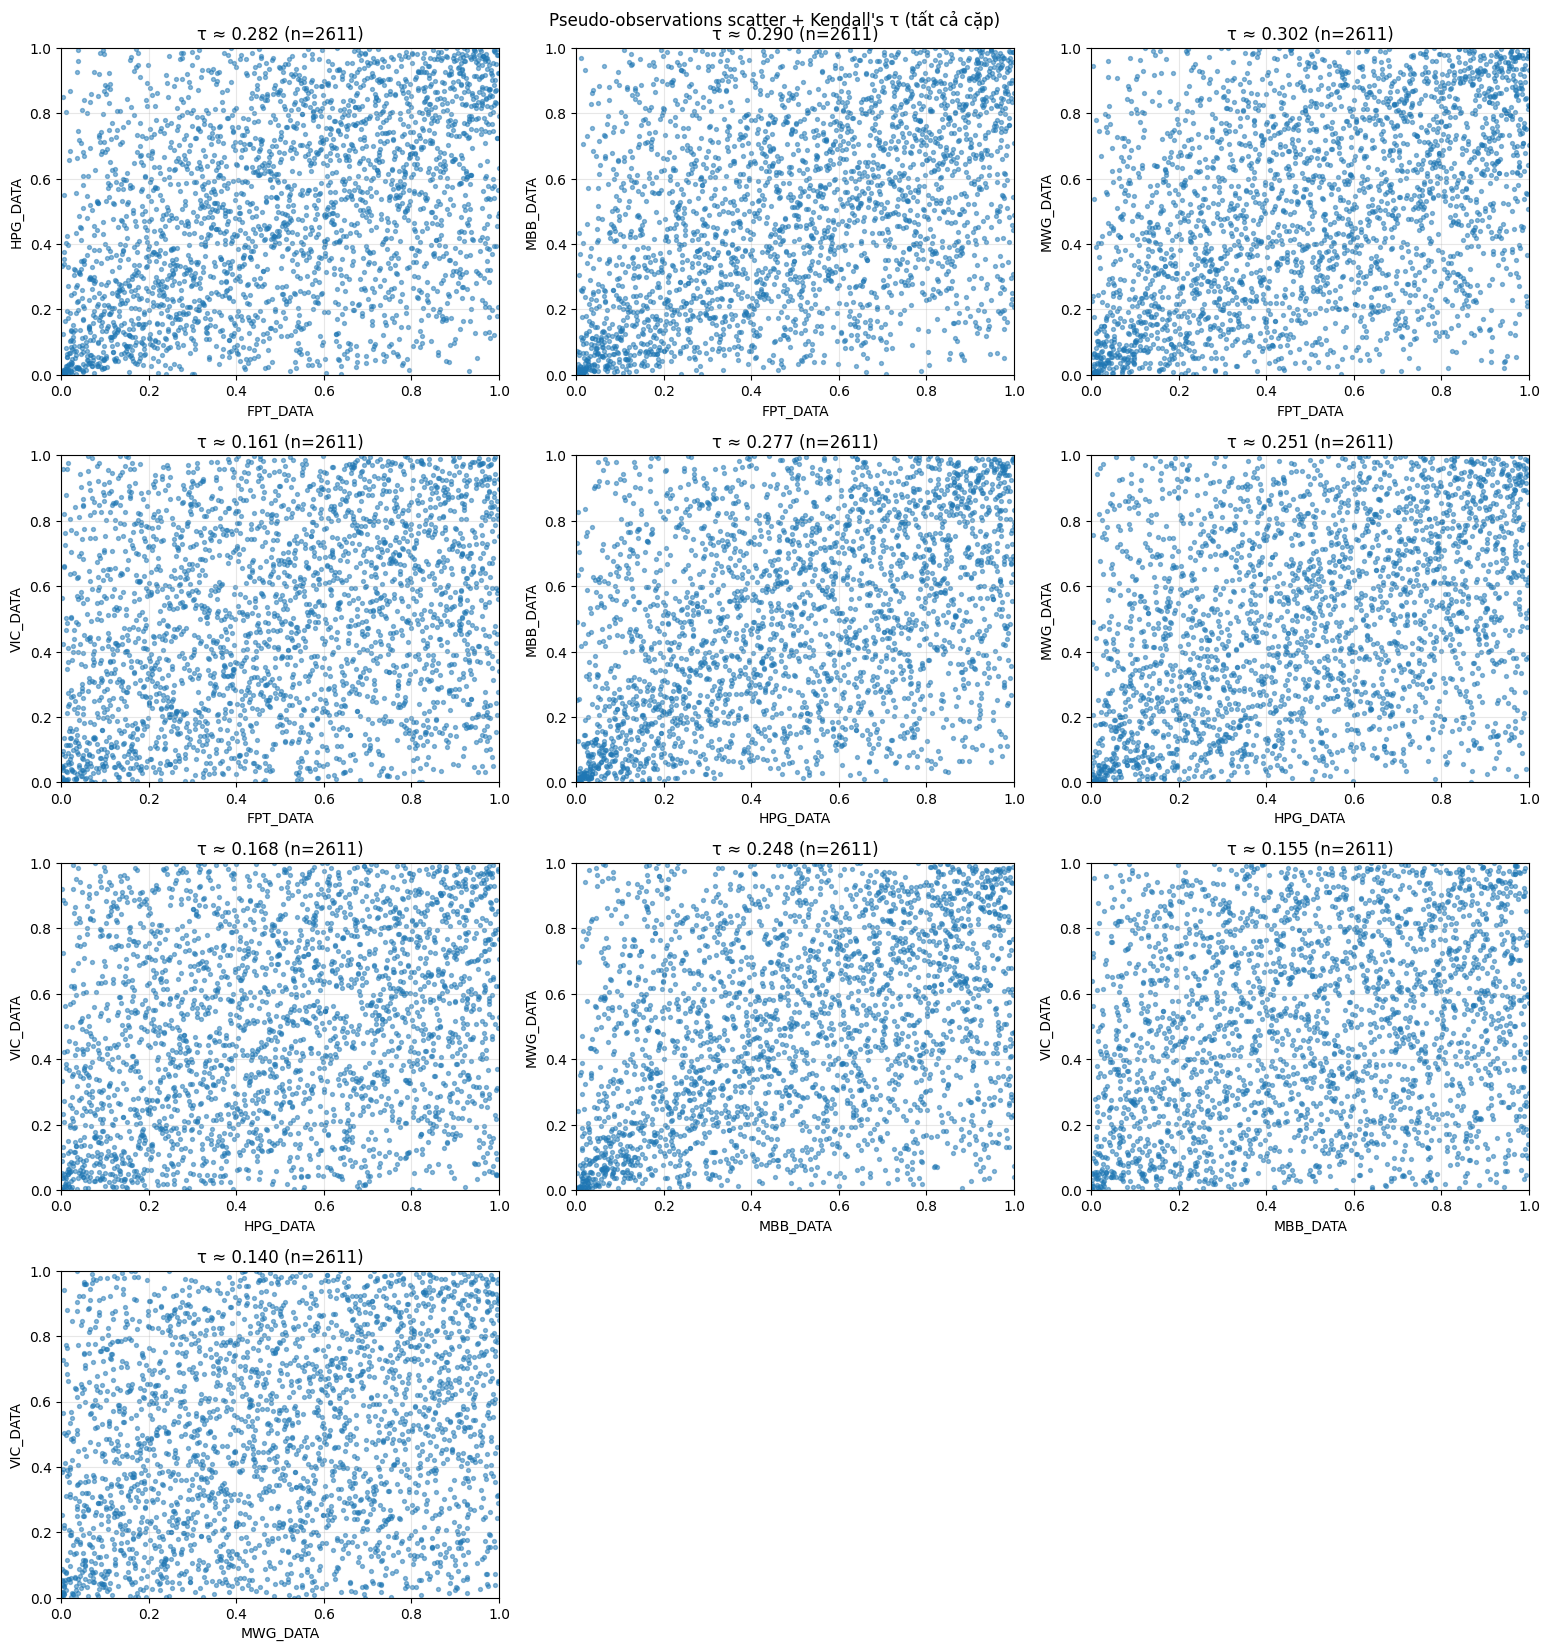

In [29]:
# Scatter plots với Kendall's tau cho tất cả cặp
import itertools
from scipy.stats import kendalltau

eps, max_cols = 1e-6, 3
cols = list(pit_df.columns)

if len(cols) < 2:
    print("Cần ít nhất 2 cột để vẽ scatter plot")
else:
    pairs = list(itertools.combinations(cols, 2))
    nrows, ncols = math.ceil(len(pairs)/max_cols), min(max_cols, len(pairs))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.2, nrows*4.2), squeeze=False)
    axes = axes.ravel()
    
    for k, (col_i, col_j) in enumerate(pairs):
        ax = axes[k]
        # Clean data và tính Kendall's tau
        df_pair = pit_df[[col_i, col_j]].dropna()
        ui, uj = np.clip(df_pair[col_i].values, eps, 1-eps), np.clip(df_pair[col_j].values, eps, 1-eps)
        tau, _ = kendalltau(ui, uj)
        
        # Plot
        ax.scatter(ui, uj, s=8, alpha=0.5)
        ax.set(xlim=(0,1), ylim=(0,1), xlabel=col_i, ylabel=col_j, title=f"τ ≈ {tau:.3f} (n={ui.size})")
        ax.grid(alpha=0.3)
    
    # Ẩn subplot thừa
    for j in range(len(pairs), len(axes)): axes[j].axis('off')
    plt.suptitle("Pseudo-observations scatter + Kendall's τ (tất cả cặp)", fontsize=12)
    plt.tight_layout(); plt.show()

- Các điểm trên scatter plot phân bố đều trong hình vuông [0,1] x [0,1], cho thấy dữ liệu PIT đã loại bỏ các đặc điểm phân phối gốc và chỉ còn lại mối quan hệ phụ thuộc giữa các biến.
- Giá trị Kendall's tau (τ) thể hiện mức độ phụ thuộc thứ tự giữa hai biến. Nếu τ gần 0, hai biến gần như độc lập; nếu τ lớn hơn, có sự phụ thuộc đồng biến rõ rệt.
- Các cặp mã cổ phiếu trong kết quả này có τ dao động từ khoảng 0.14 đến 0.30, cho thấy tồn tại mức độ phụ thuộc vừa phải giữa các tài sản trong danh mục.

## 3. Fit mô hình R-vine copula và thực hiện mô phỏng

Ở bước này, mô hình R-vine copula được fit lên dữ liệu PIT để mô phỏng cấu trúc phụ thuộc đa biến giữa các tài sản trong danh mục.

**Lý thuyết R-vine copula:**
- R-vine (Regular vine) là một lớp mô hình copula đa biến linh hoạt, cho phép mô tả cấu trúc phụ thuộc phức tạp giữa nhiều biến thông qua các copula cặp (pair-copula construction).
- Một R-vine được xây dựng từ một chuỗi các cây (trees), trong đó mỗi cạnh (edge) đại diện cho một copula cặp giữa hai biến (hoặc điều kiện trên các biến khác).
- Ưu điểm của R-vine là khả năng kết hợp nhiều loại copula cặp khác nhau (Gaussian, t, Clayton, Gumbel, v.v.) để mô hình hóa các kiểu phụ thuộc khác nhau (đồng biến, tail dependence, v.v.).
- Việc lựa chọn cấu trúc cây và loại copula cặp được thực hiện tự động dựa trên dữ liệu, giúp mô hình nắm bắt tốt nhất các mối quan hệ phụ thuộc thực tế.

Fit R-vine copula giúp mô hình hóa chính xác cấu trúc phụ thuộc giữa các tài sản, vượt xa các mô hình copula đơn giản như Gaussian copula. Kết quả fit sẽ được sử dụng để mô phỏng dữ liệu danh mục đầu tư, phục vụ cho các phân tích rủi ro tiếp theo.

### Quy trình mô phỏng danh mục đầu tư bằng copula và EVT marginals

Quy trình mô phỏng (simulate) sử dụng mô hình copula đã fit và các phân phối biên EVT để tạo ra các mẫu dữ liệu giả lập cho danh mục đầu tư. Các bước chính gồm:

1. **Nạp mô hình copula và phân phối biên**: Đọc mô hình copula đã fit (R-vine copula) và các phân phối biên EVT từ file.
2. **Sinh mẫu ngẫu nhiên từ copula**: Sử dụng copula để sinh ra các bộ giá trị ngẫu nhiên có cấu trúc phụ thuộc giống như dữ liệu thực tế.
3. **Biến đổi ngược về không gian gốc**: Các giá trị ngẫu nhiên từ copula (trong không gian [0,1]) được biến đổi ngược về không gian giá trị thực tế bằng các phân phối biên EVT đã fit cho từng tài sản.
4. **Lưu kết quả mô phỏng**: Các mẫu mô phỏng được lưu ra file để phục vụ cho các phân tích rủi ro tiếp theo (VaR, ES, thống kê mô tả, v.v.).

Quy trình này cho phép tạo ra các kịch bản rủi ro giả lập cho danh mục đầu tư, phản ánh đúng cả đặc điểm phân phối biên và cấu trúc phụ thuộc đa biến giữa các tài sản, giúp đánh giá rủi ro một cách toàn diện và thực tế hơn.

In [45]:
evt_params_path = '../models/evt/marginal_distributions.pkl'
simulated_copula_path = '../data/processed/simulated_copula.csv'


print(f"Loading copula model from: {output_path}")
print(f"Loading standardized residuals from: {std_resids_path}")
print(f"Loading EVT params from: {evt_params_path}")

best_copula_model, marginals = load_copula_and_marginals(output_path, std_resids_path, evt_params_path)

print(f"Simulating 10000 samples...")
simulate_copula_portfolio(best_copula_model, marginals, n_sim=10000, output_path=simulated_copula_path)

Loading copula model from: ../models/copula/best_copula.json
Loading standardized residuals from: ../models/garch/standardized_residuals.csv
Loading EVT params from: ../models/evt/marginal_distributions.pkl
Simulating 10000 samples...
Simulated samples saved to: ../data/processed/simulated_copula.csv


,FPT_DATA,HPG_DATA,MBB_DATA,MWG_DATA,VIC_DATA
0,-0.188942,1.172571,0.681556,-0.283232,0.092916
1,-0.127989,0.150780,0.120036,0.147953,0.037364
2,-0.749094,0.181800,-1.098076,-0.510427,0.151367
3,0.088364,0.026090,1.077623,-0.736576,0.347515
4,-1.000189,-0.558849,-0.714554,-0.949819,-0.412509
...,...,...,...,...,...
9995,-3.492791,-2.709007,-0.726104,-1.278499,-0.898230
9996,-1.022397,-0.064091,0.250193,-1.163617,-0.009033
9997,-2.646337,-2.187564,-1.958580,-3.011052,-1.694957
9998,-1.257840,-1.039717,-0.702284,0.725519,-0.008544


### Kết quả mô phỏng và so sánh với dữ liệu thực tế

In [46]:
simulated_data_path = '../data/processed/simulated_copula.csv'
results = analyze_simulated_data(simulated_data_path, real_csv_path=std_resids_path, alpha=0.05)

# Print summary statistics
print('--- Thống kê mô tả dữ liệu mô phỏng ---')
print(results['sim_stats'])

print(f'\n--- VaR(5%) và ES(5%) từng tài sản ---')
for col, risk in results['individual_risk'].items():
    print(f'{col}: VaR={risk["VaR"]:.4f}, ES={risk["ES"]:.4f}')

print(f'\nPortfolio VaR(5%): {results["portfolio_risk"]["VaR"]:.4f}, ES: {results["portfolio_risk"]["ES"]:.4f}')

if 'real_stats' in results:
    print('\n--- Thống kê mô tả dữ liệu thực tế ---')
    print(results['real_stats'])

--- Thống kê mô tả dữ liệu mô phỏng ---
           FPT_DATA      HPG_DATA      MBB_DATA      MWG_DATA      VIC_DATA
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.037878      0.020332      0.038758      0.023365     -0.002441
std        0.951772      0.998335      0.956305      0.994967      0.460970
min       -6.761077     -6.100289     -5.179379     -5.787121     -4.158984
25%       -0.490516     -0.576324     -0.499477     -0.512545     -0.204664
50%        0.009655     -0.007786      0.017477      0.024097     -0.010505
75%        0.512408      0.570895      0.525678      0.515613      0.176300
max        6.476357      4.382314      6.235275      4.553503      3.846431

--- VaR(5%) và ES(5%) từng tài sản ---
FPT_DATA: VaR=-1.3849, ES=-2.0028
HPG_DATA: VaR=-1.5414, ES=-2.1864
MBB_DATA: VaR=-1.4322, ES=-2.0887
MWG_DATA: VaR=-1.5407, ES=-2.2103
VIC_DATA: VaR=-0.6451, ES=-1.0699

Portfolio VaR(5%): -0.9732, ES: -1.4673

--- Thống kê mô tả dữ li

**1. Thống kê mô tả dữ liệu mô phỏng:**
- Các giá trị trung bình, độ lệch chuẩn, min/max và các phân vị (25%, 50%, 75%) của từng mã cổ phiếu trong dữ liệu mô phỏng đều rất gần với dữ liệu thực tế.
- Điều này cho thấy mô hình copula kết hợp với phân phối biên EVT đã mô phỏng sát đặc điểm phân phối gốc của từng tài sản.

**2. VaR(5%) và ES(5%) từng tài sản:**
- VaR(5%) là mức lỗ lớn nhất có thể xảy ra với xác suất 5%, ES(5%) là mức lỗ trung bình khi vượt ngưỡng VaR.
- Các giá trị VaR và ES của từng mã cổ phiếu trong mô phỏng đều tương đương với thực tế, phản ánh khả năng mô phỏng rủi ro tail risk tốt của mô hình.
- VIC_DATA có VaR và ES thấp hơn các mã khác, cho thấy rủi ro tail của mã này nhỏ hơn.

**3. VaR và ES của toàn bộ danh mục:**
- Portfolio VaR(5%) = -0.9732, ES = -1.4673 cho thấy mức rủi ro tổng thể của danh mục khi các tài sản kết hợp với nhau.
- Giá trị này thấp hơn so với từng mã riêng lẻ, phản ánh hiệu ứng đa dạng hóa rủi ro trong danh mục.

**4. So sánh với dữ liệu thực tế:**
- Các thống kê mô tả của dữ liệu mô phỏng và thực tế gần như trùng khớp, xác nhận chất lượng mô phỏng của mô hình copula.
- Điều này chứng tỏ mô hình đã nắm bắt tốt cả đặc điểm phân phối biên và cấu trúc phụ thuộc giữa các tài sản.

**Kết luận:**
Mô hình copula kết hợp EVT đã mô phỏng sát thực tế, cung cấp các chỉ số rủi ro (VaR, ES) đáng tin cậy cho từng tài sản và toàn bộ danh mục. Đây là công cụ mạnh mẽ để đánh giá rủi ro tài chính trong điều kiện thị trường biến động.

### Biểu đồ so sánh phân phối mô phỏng và thực tế

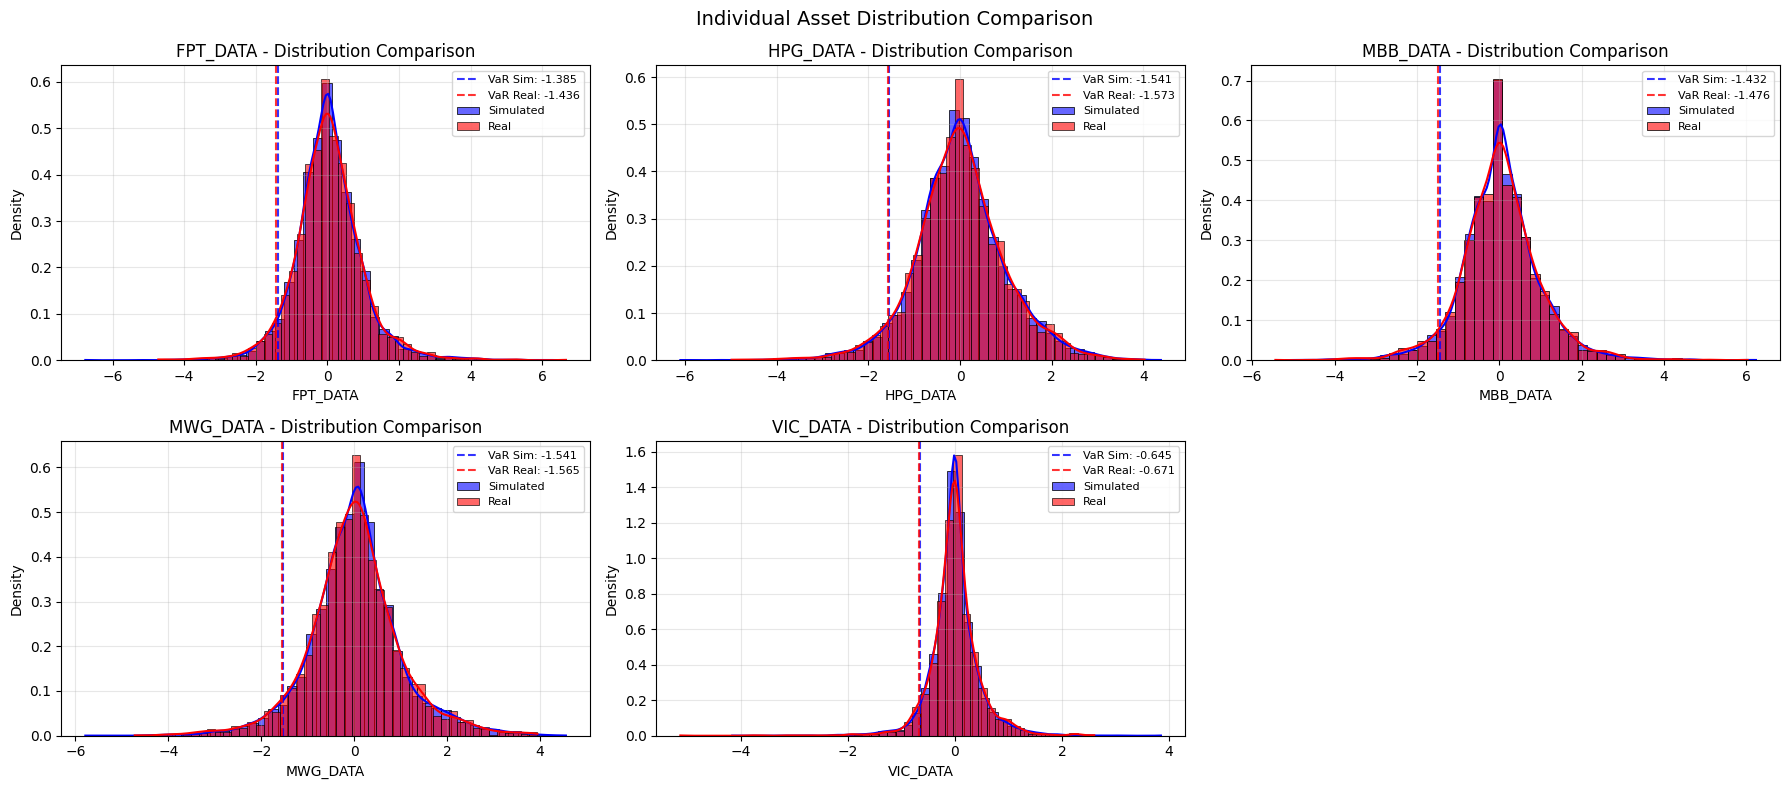

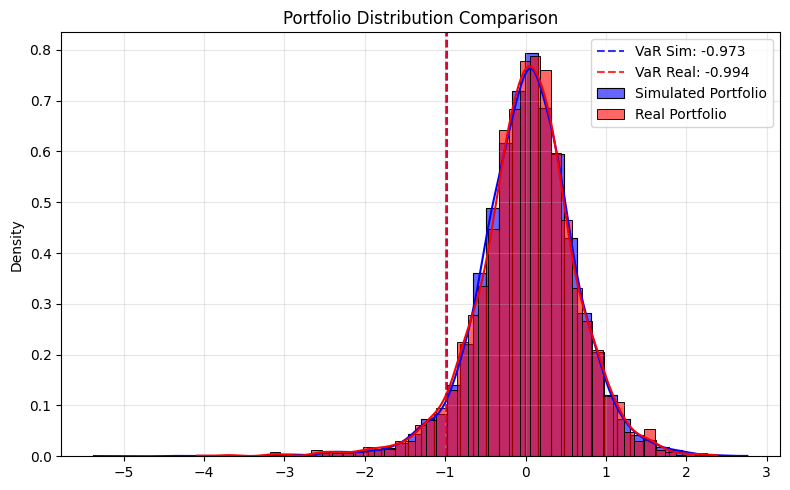

In [47]:
plot_histogram_comparison(results, bins=50, max_cols=3)

**1. Biểu đồ so sánh phân phối từng tài sản:**
- Mỗi subplot thể hiện sự so sánh giữa phân phối dữ liệu mô phỏng (màu xanh) và dữ liệu thực tế (màu đỏ) cho từng mã cổ phiếu.
- Đường và cột histogram của hai nguồn dữ liệu gần như trùng khớp, cho thấy mô hình copula kết hợp EVT đã mô phỏng sát đặc điểm phân phối gốc của từng tài sản.
- Vị trí VaR(5%) của mô phỏng và thực tế (đường nét đứt) cũng rất gần nhau, xác nhận khả năng mô phỏng tail risk của mô hình.
- Điều này chứng minh mô hình không chỉ khớp về trung tâm phân phối mà còn nắm bắt tốt các đặc điểm ở vùng tail (rủi ro cực đoan).

**2. Biểu đồ so sánh phân phối toàn bộ danh mục:**
- Biểu đồ này so sánh phân phối tổng hợp của danh mục đầu tư (kết hợp các tài sản) giữa dữ liệu mô phỏng và thực tế.
- Đường phân phối và histogram của hai nguồn dữ liệu gần như trùng khớp, cho thấy mô hình đã mô phỏng đúng hiệu ứng đa dạng hóa rủi ro trong danh mục.
- Vị trí VaR(5%) của danh mục mô phỏng và thực tế cũng rất gần nhau, xác nhận chất lượng mô phỏng tổng thể.
- Kết quả này cho thấy mô hình copula không chỉ mô phỏng tốt từng tài sản mà còn nắm bắt chính xác cấu trúc phụ thuộc đa biến, giúp đánh giá rủi ro danh mục một cách thực tế và toàn diện.

**Kết luận:**
Hai biểu đồ này là bằng chứng trực quan cho thấy mô hình copula + EVT đã mô phỏng sát thực tế cả về phân phối từng tài sản lẫn toàn bộ danh mục, đặc biệt ở vùng tail (rủi ro lớn).

### Biểu đồ quan hệ và tương quan


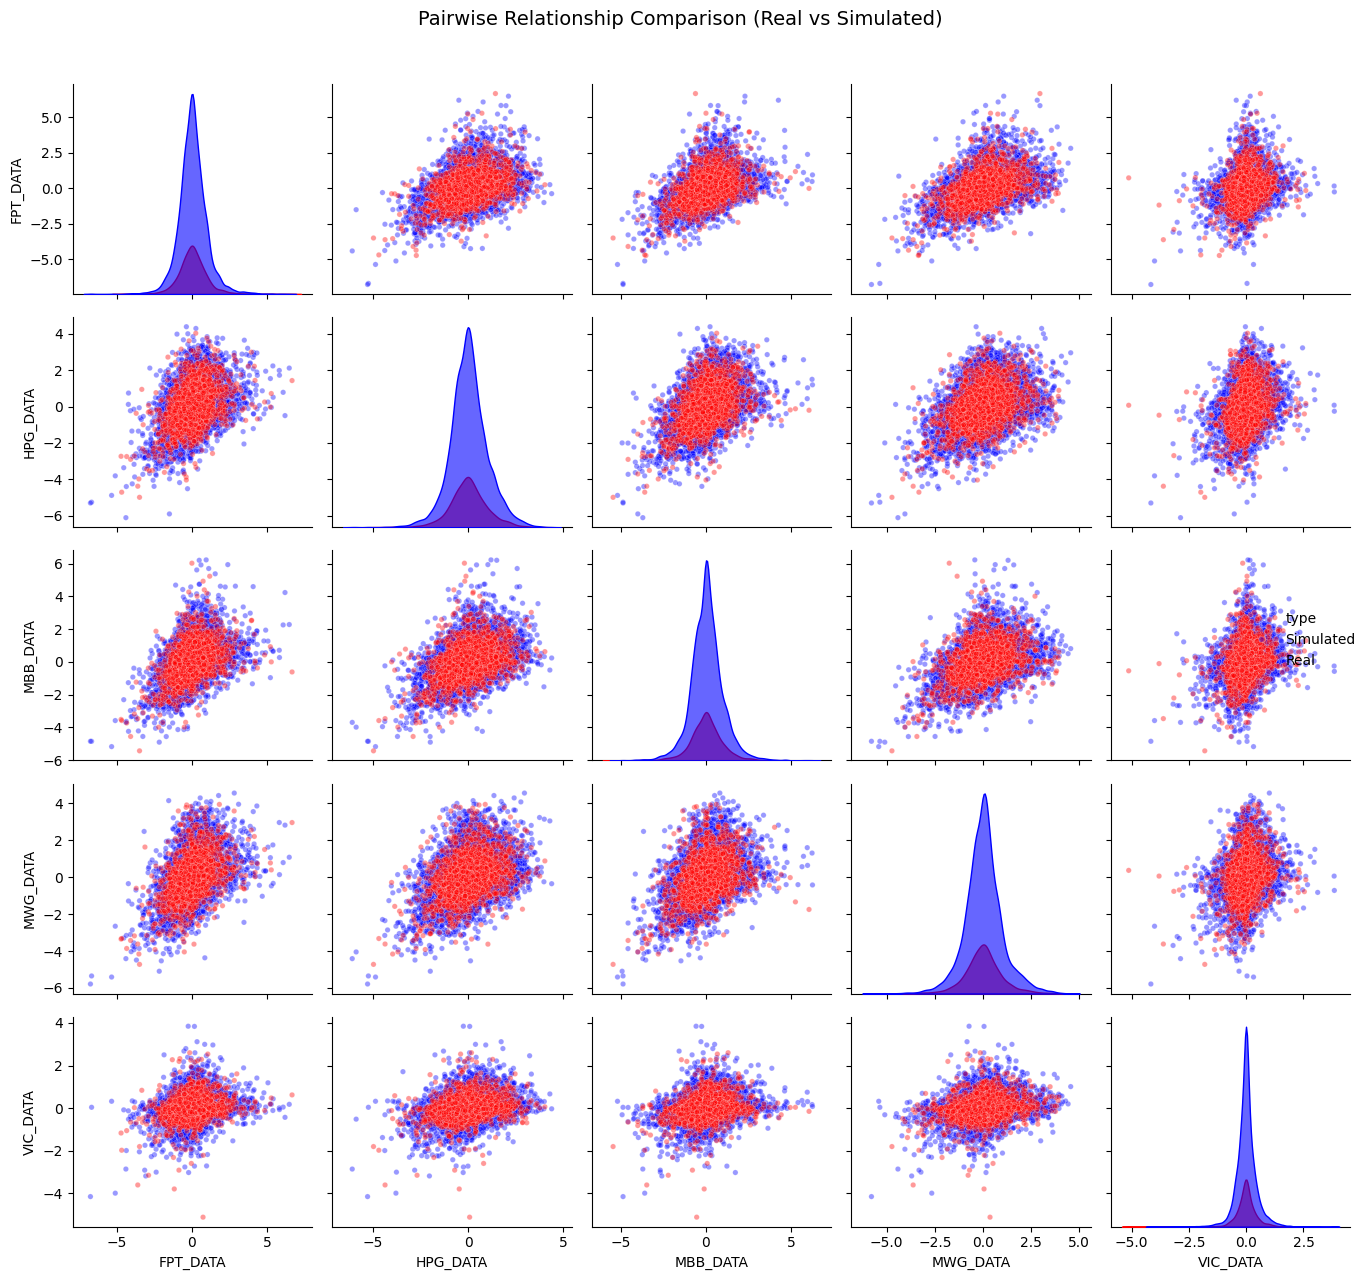

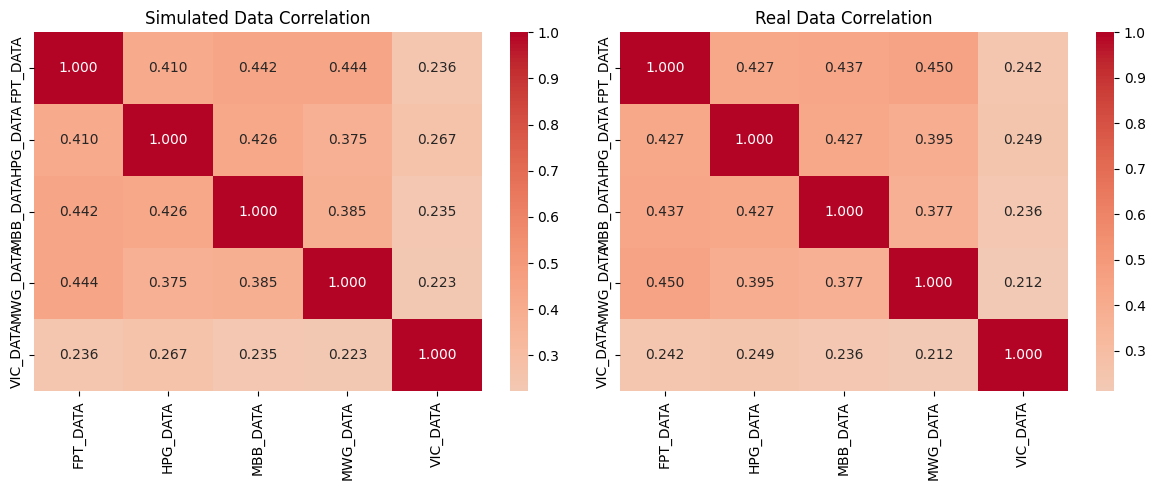

In [48]:
plot_pairplot_comparison(results, sample_size=10000)

**Pairplot (so sánh từng cặp tài sản):**
- Biểu đồ này trực quan hóa mối quan hệ giữa từng cặp tài sản, với dữ liệu mô phỏng (xanh) và thực tế (đỏ) được đặt cạnh nhau.
- Các đám mây điểm của hai nguồn dữ liệu phân bố gần như trùng khớp, cho thấy mô hình copula đã tái tạo tốt cấu trúc phụ thuộc đa biến.
- Phân phối biên của từng mã (đường viền dọc) cũng khớp sát, xác nhận chất lượng mô phỏng ở cả mức độ từng biến và từng cặp.
- Nếu có sự khác biệt lớn về hình dạng hoặc mật độ, đó là dấu hiệu mô hình chưa nắm bắt hết đặc điểm thực tế.

**Heatmap ma trận tương quan:**
- Hai heatmap thể hiện mức độ tương quan giữa các tài sản trong dữ liệu mô phỏng và thực tế.
- Các giá trị tương quan của từng cặp mã gần như giống nhau, chứng minh mô hình copula đã nắm bắt đúng mức độ liên hệ giữa các tài sản.
- Điều này rất quan trọng vì tương quan ảnh hưởng trực tiếp đến rủi ro tổng thể của danh mục.
- Nếu có sự khác biệt lớn về màu sắc hoặc giá trị, cần kiểm tra lại bước fit copula hoặc phân phối biên.